In [1]:
# plotly standard imports
import plotly.graph_objs as go
import chart_studio.plotly as py

# Cufflinks wrapper on plotly
import cufflinks

# Data science imports
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot, init_notebook_mode
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Load dataset
And get interesting features

In [16]:
from src.load_datasets import load_datasets
from src.prepare_datasets import feature_list

train, test = load_datasets()

train_features = train[feature_list]
test_features = test[feature_list]

train_features.index = train['Date']
test_features.index = test['Date']

train_features

High          Low         Open        Close  \
Date                                                                      
2017-03-01 23:59:59  1222.500000  1179.689941  1180.040039  1222.500000   
2017-03-02 23:59:59  1262.130005  1215.619995  1224.680054  1251.010010   
2017-03-03 23:59:59  1280.310059  1250.709961  1250.709961  1274.989990   
2017-03-04 23:59:59  1279.400024  1230.510010  1277.430054  1255.150024   
2017-03-05 23:59:59  1267.290039  1238.060059  1254.290039  1267.119995   
...                          ...          ...          ...          ...   
2020-05-07 23:59:59  9992.663921  9138.322572  9261.895058  9951.518745   
2020-05-08 23:59:59  9996.743353  9767.173070  9936.162482  9842.666368   
2020-05-09 23:59:59  9913.862993  9580.644492  9840.906384  9593.896734   
2020-05-10 23:59:59  9595.580629  8395.107451  9591.169231  8756.431142   
2020-05-11 23:59:59  9033.471176  8374.322975  8755.535639  8601.796202   

                           Volume  
Date                               
2017-03-01 23:59:59  2.290570e+08  
2017-03-02 23:59:59  3.682750e+08  
2017-03-03 23:59:59  3.157390e+08  
2017-03-04 23:59:59  1.832700e+08  
2017-03-05 23:59:59  1.341270e+08  
...                           ...  
2020-05-07 23:59:59  6.111270e+10  
2020-05-08 23:59:59  5.178075e+10  
2020-05-09 23:59:59  4.656612e+10  
2020-05-10 23:59:59  6.332528e+10  
2020-05-11 23:59:59  5.711986e+10  

[1168 rows x 5 columns]

# Data featuring

In theory we are going to use 4 features: The price itself and three extra technical indicators.

MACD (Trend)
Stochastics (Momentum)
Average True Range (Volume)

## Functions

**Exponential Moving Average**: Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero.

**MACD**: The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

**Stochastics oscillator**: The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

**Average True Range**: Is an indicator to measure the volalitility (NOT price direction). The largest of:

- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

In [3]:
from src.indicators import MACD, stochastics_oscillator, ATR

In [4]:
days_to_show = 120

## MACD

In [6]:
macd = MACD(train_features['Close'][-days_to_show:], 12, 26, 9)

pd.DataFrame({'MACD': macd}).iplot()

## Stochastics Oscillator

In [7]:
stochastics = stochastics_oscillator(train_features['Close'][-days_to_show:], 14)

pd.DataFrame({'Stochastics Oscillator': stochastics}).iplot()

## Average True Range

In [8]:
atr = ATR(train_features.iloc[-days_to_show:], 14)

atr.head()

atr.iplot()

0
Date                           
2020-01-13 23:59:59  118.087438
2020-01-14 23:59:59  738.578430
2020-01-15 23:59:59  232.929973
2020-01-16 23:59:59  234.365262
2020-01-17 23:59:59  280.805603

## Check for normal distribution

Date
2017-03-02 23:59:59    0.023321
2017-03-03 23:59:59    0.019168
2017-03-04 23:59:59   -0.015561
2017-03-05 23:59:59    0.009537
2017-03-06 23:59:59    0.004506
Name: Close, dtype: float64

((array([-3.24185118, -2.97999187, -2.83407736, ...,  2.83407736,
          2.97999187,  3.24185118]),
  array([-0.37169541, -0.18741101, -0.16854801, ...,  0.19928334,
          0.23936087,  0.25247169])),
 (0.04261248067886907, 0.0026680430364167313, 0.9584360013699854))

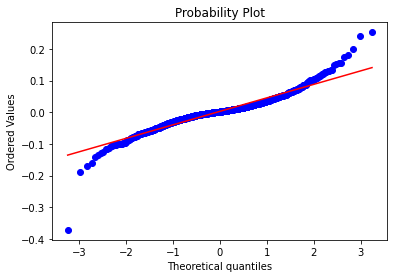

In [10]:
import scipy.stats as stats
import pylab

close_change = train_features['Close'].pct_change()[1:]
close_change.head()

stats.probplot(close_change, dist='norm', plot=pylab)

### Check time relation

Check depenence of trading and price from date in year and time of day

#### Firstly define function for display frequiency

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_log_freaquency(series):
    fft = tf.signal.rfft(series)    
    f_per_dataset = np.arange(0, len(fft))

    n_samples_d = len(series)
    days_per_year = 365
    years_per_dataset = n_samples_d/(days_per_year)

    f_per_year = f_per_dataset/years_per_dataset
    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.xticks([1, 365], labels=['1/Year', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')

#### Frequency of price

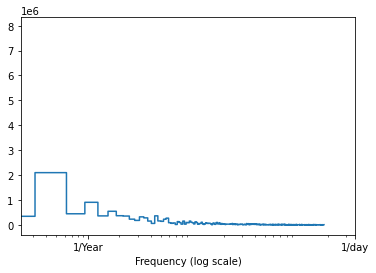

In [13]:
plot_log_freaquency(train_features['Close'])

#### Frequency of transaction volume

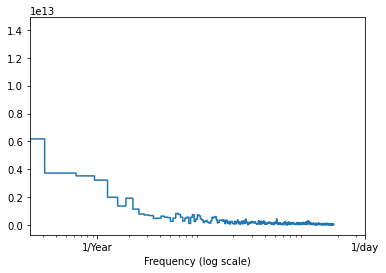

In [15]:
plot_log_freaquency(train_features['Volume'])

## Compare train and test datasets

                                             |          | [  0%]   00:00 -> (? left)


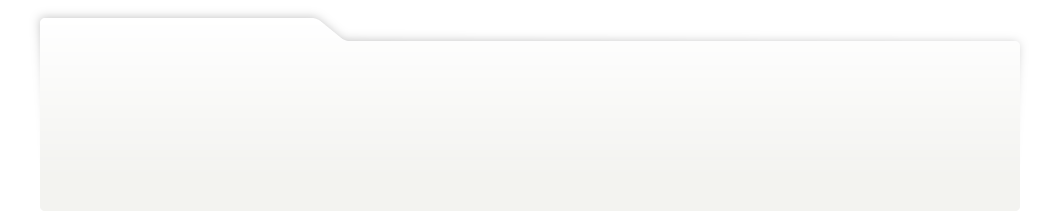
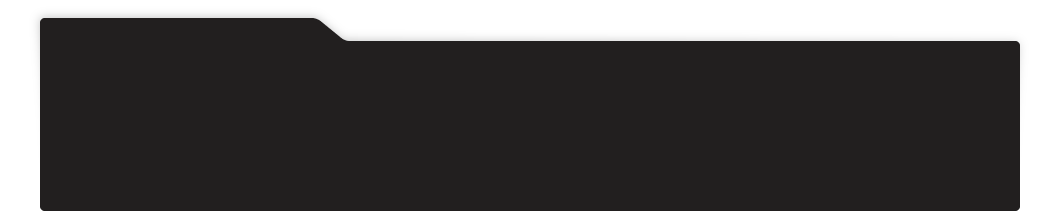
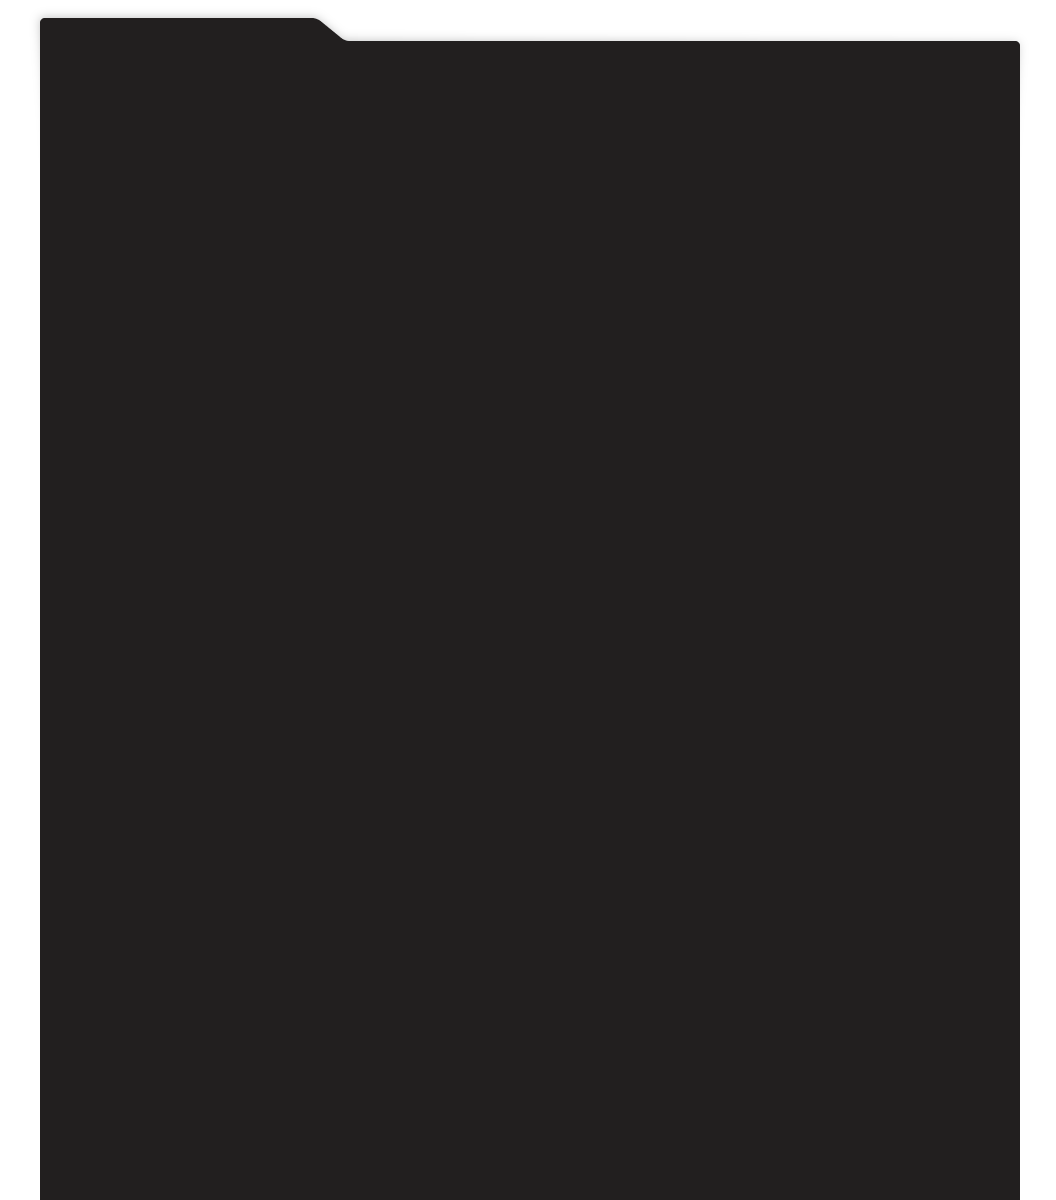
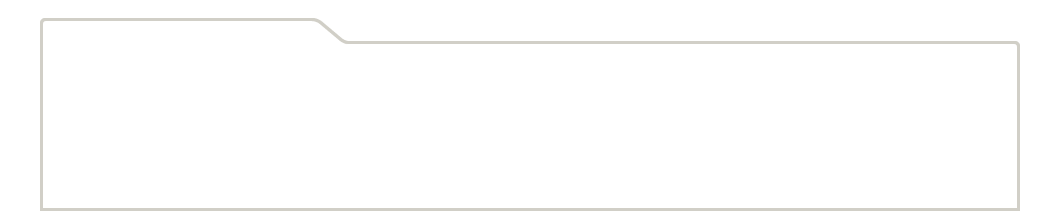
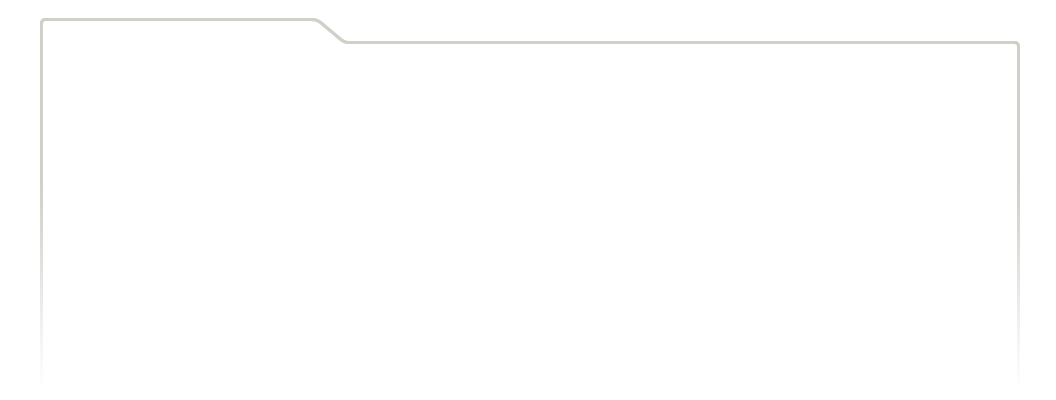
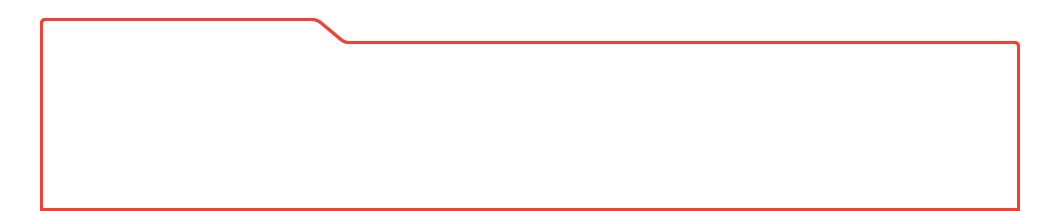
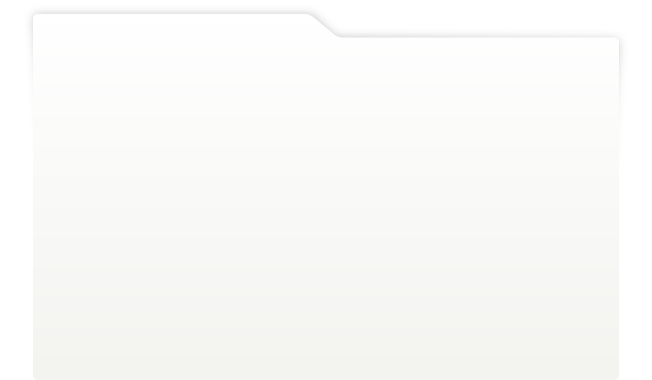
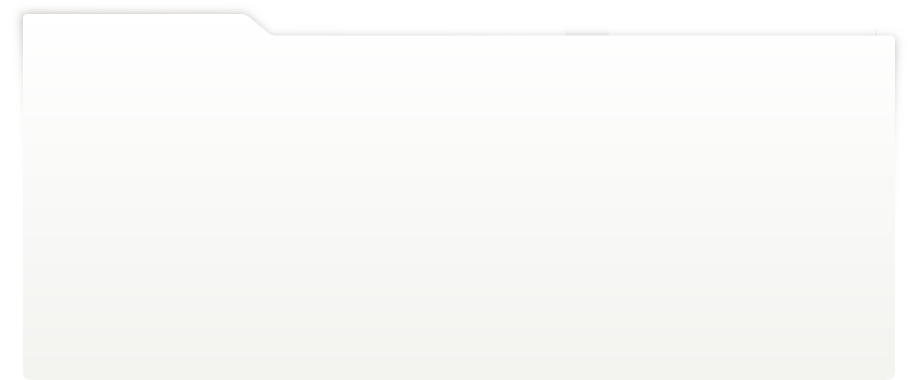
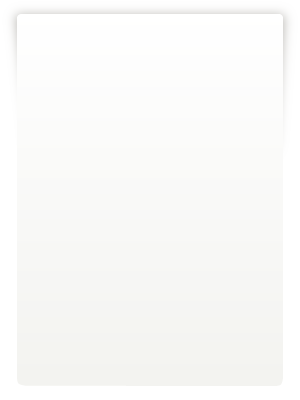
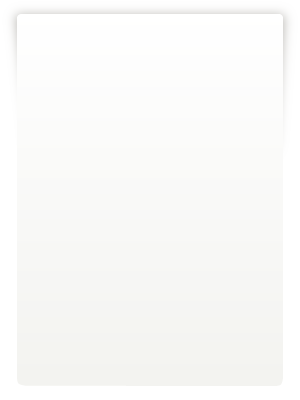
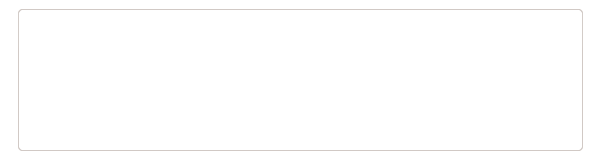
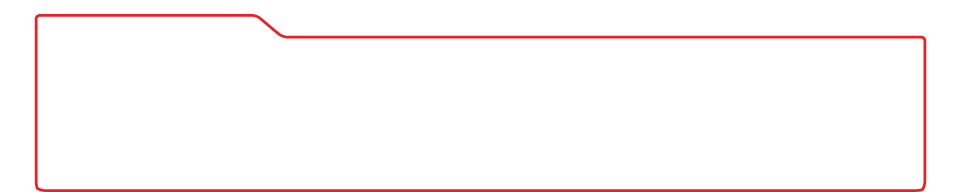
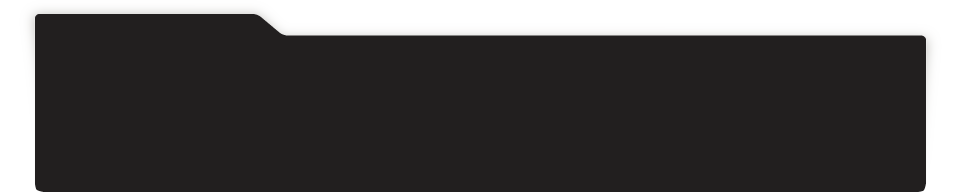
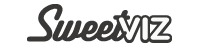
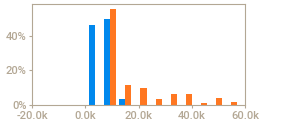
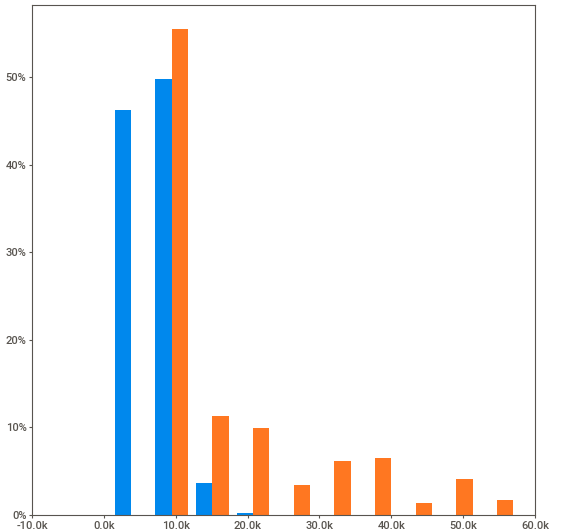
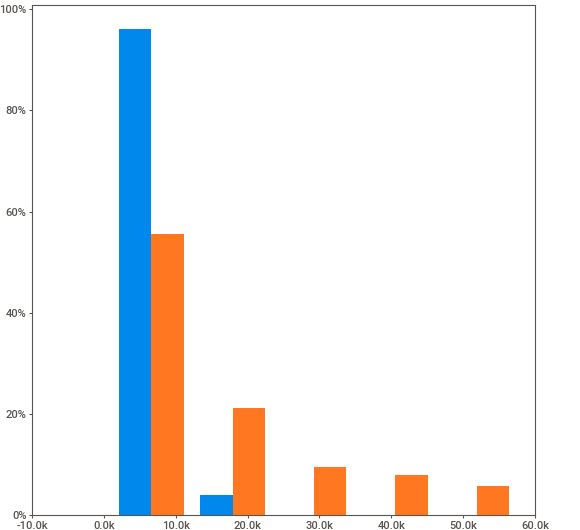
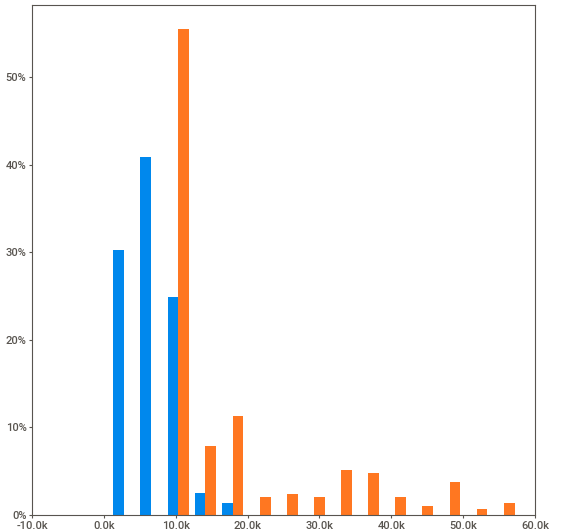
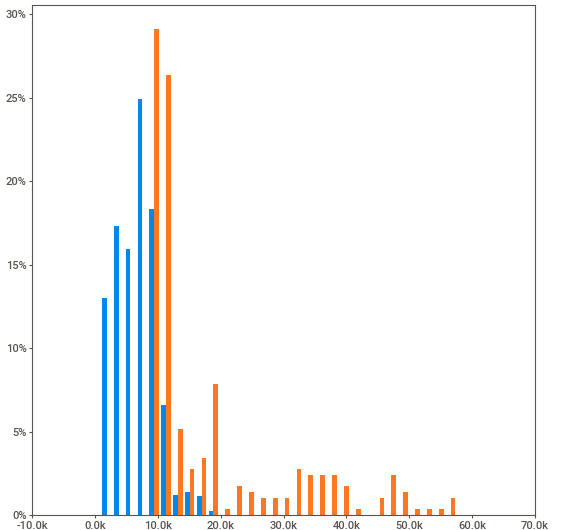
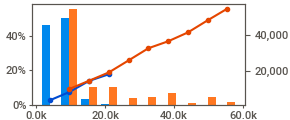
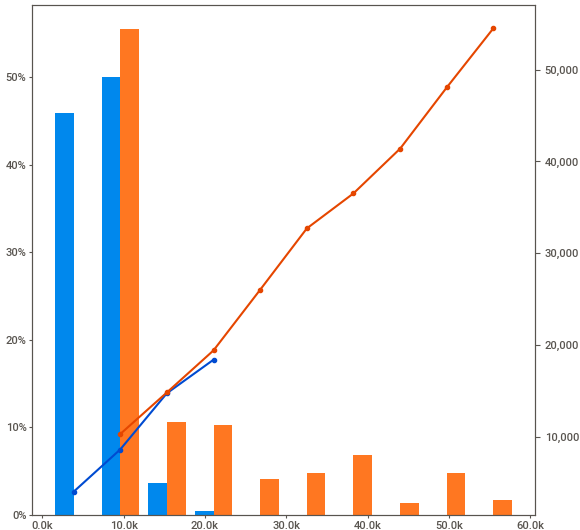
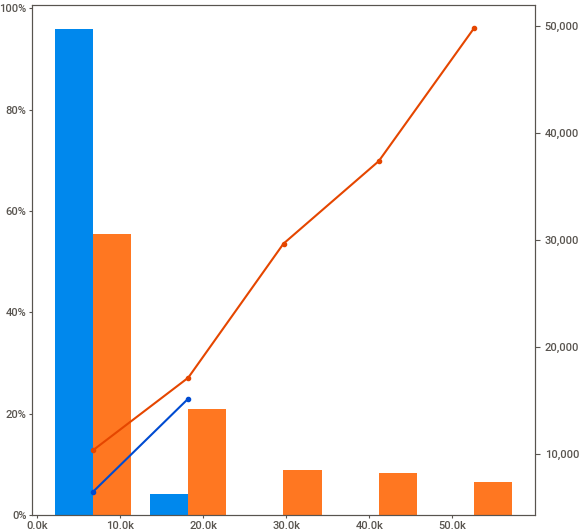
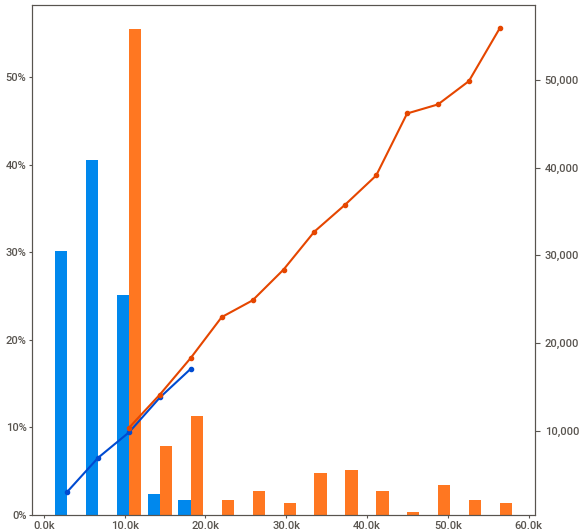
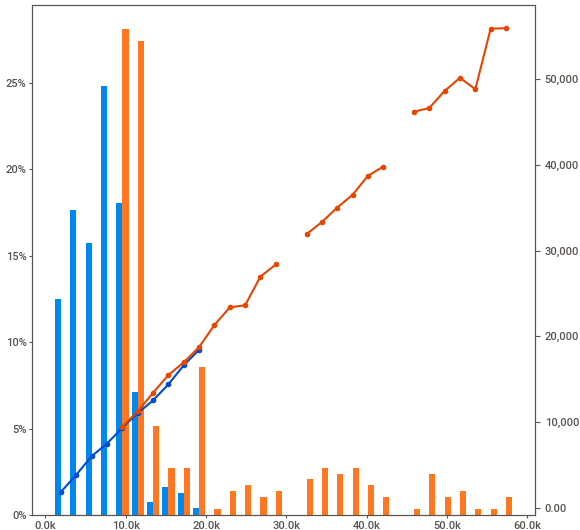
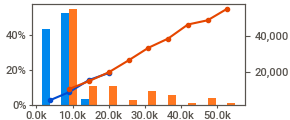
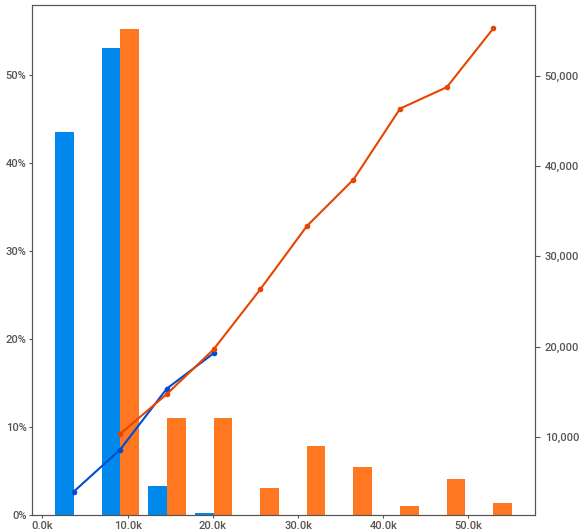
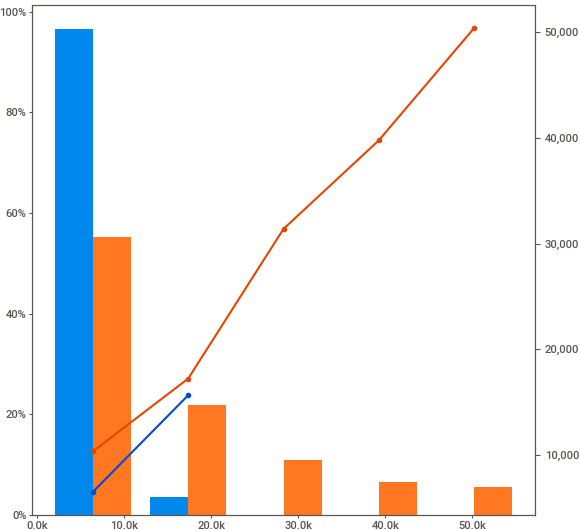
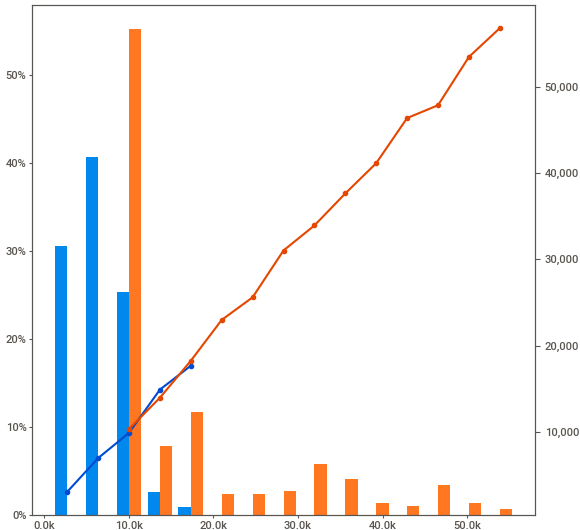
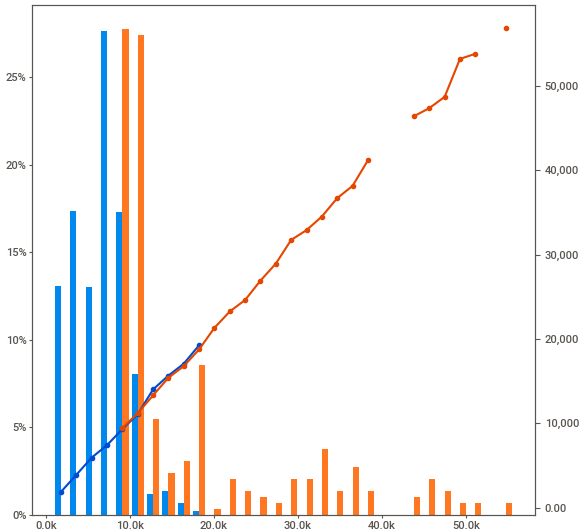
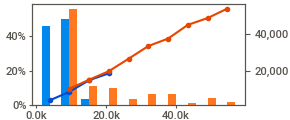
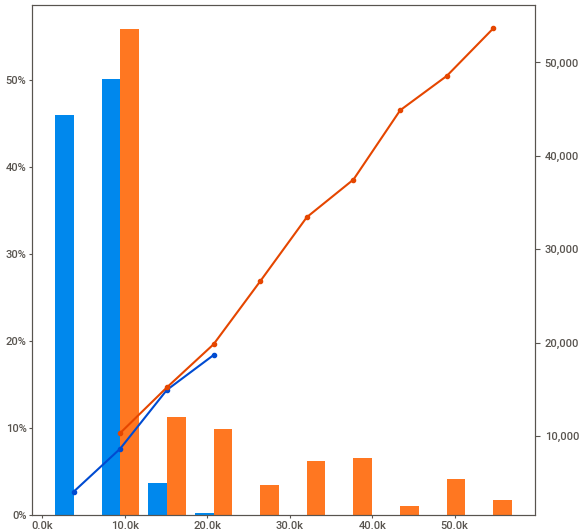
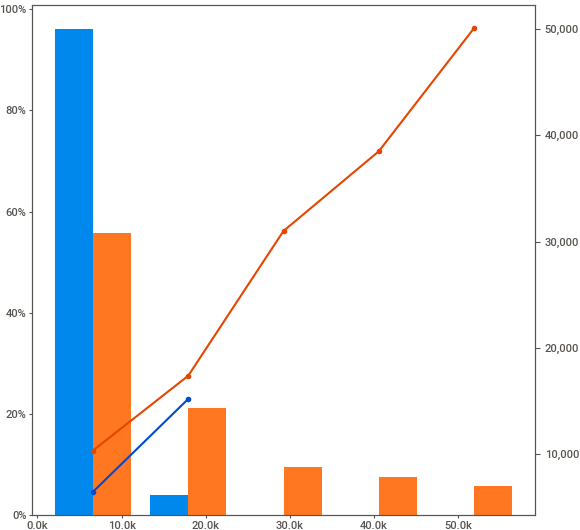
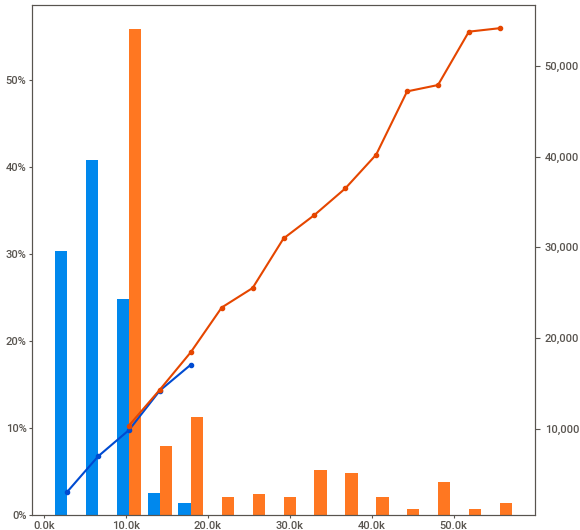
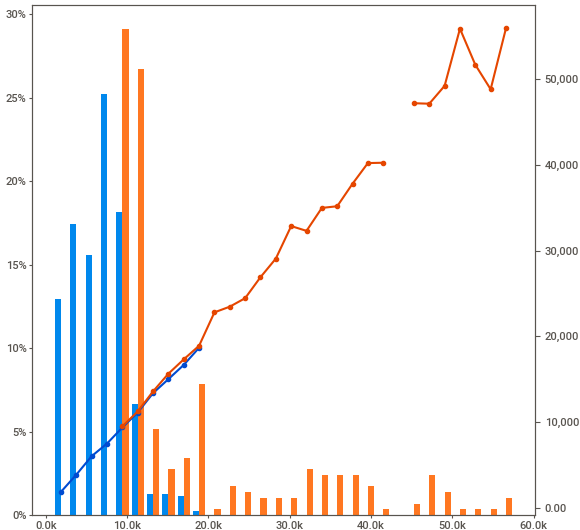
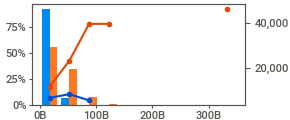
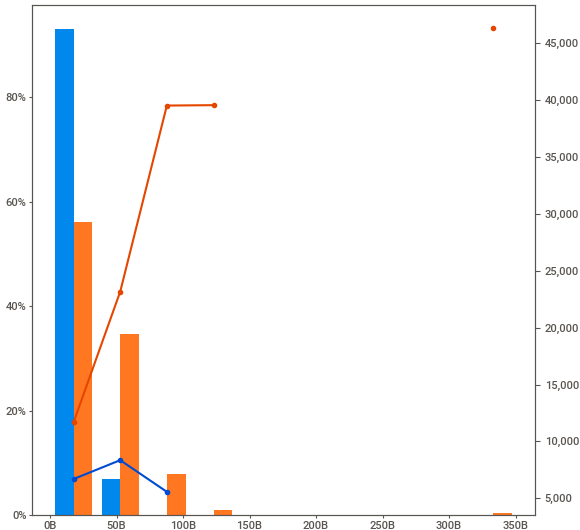
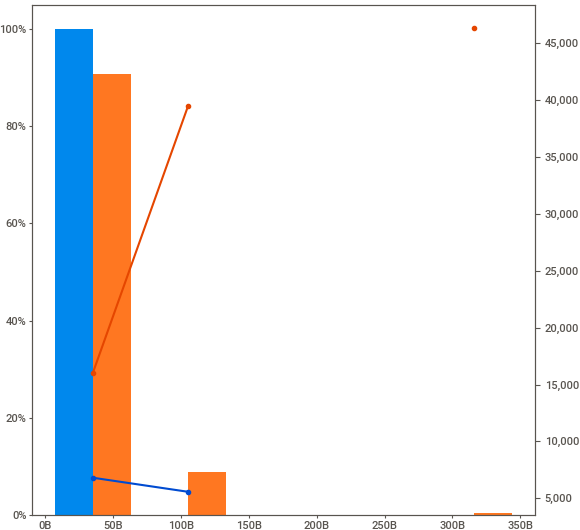
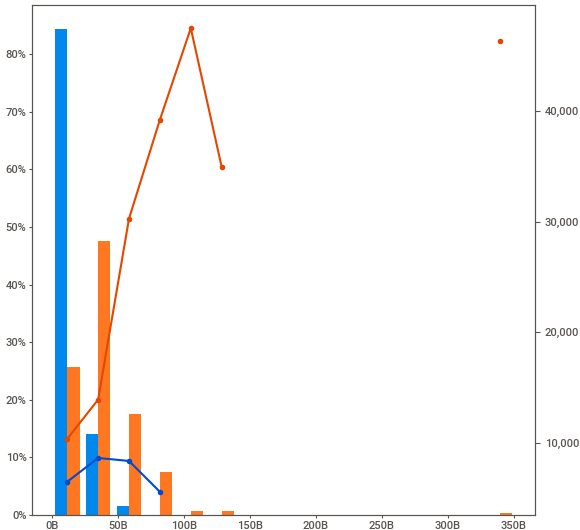
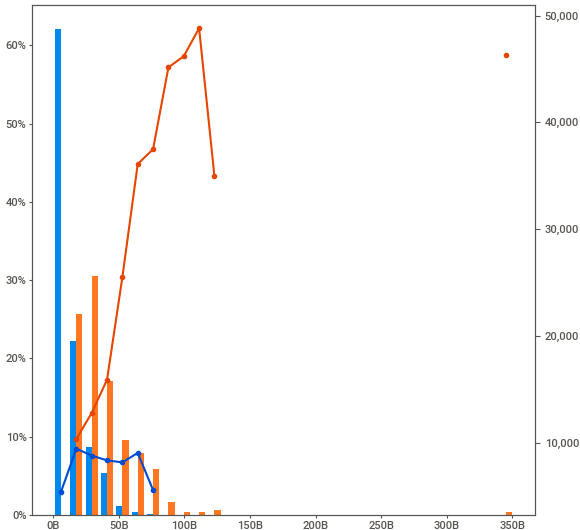
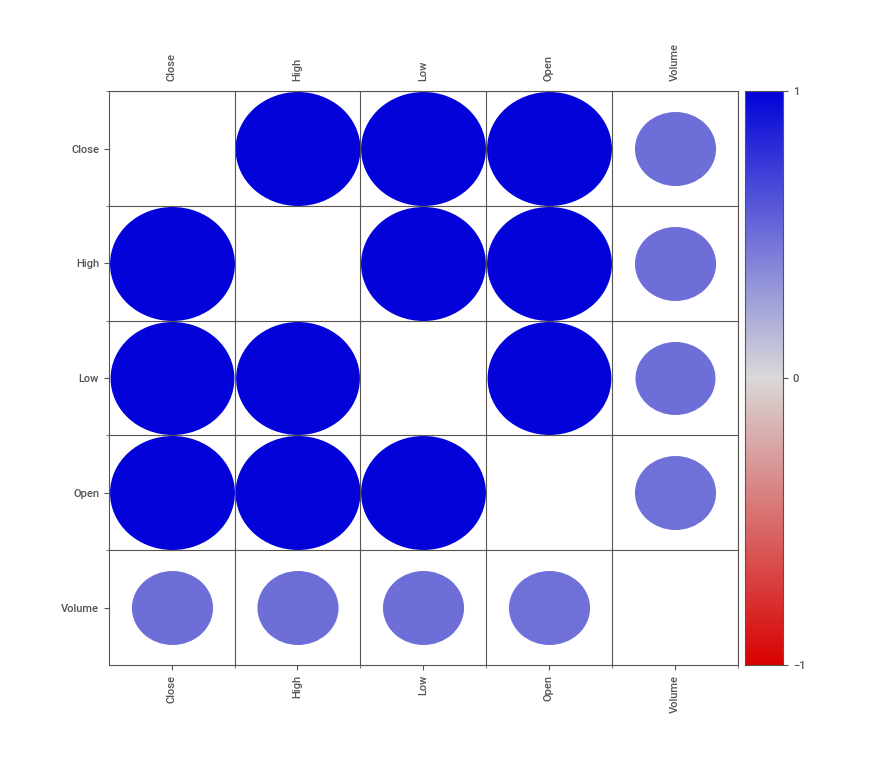
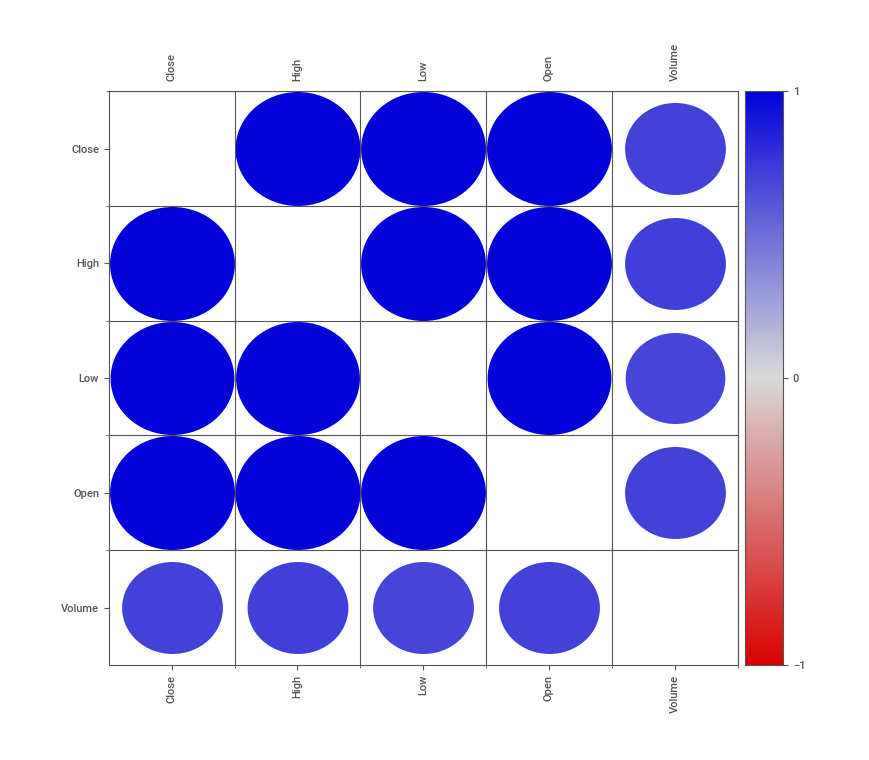

In [17]:
import sweetviz as sv

compare_report = sv.compare([train_features, 'Train data'], [test_features, 'Test data'], "Close")
compare_report.show_notebook()

### Training data exploration

In [18]:
train_features.iplot(subplots=True)

### Testing data exploration

In [20]:
test_features

High           Low          Open         Close  \
Date                                                                          
2020-05-12 23:59:59   8949.897979   8569.643988   8610.386212   8804.477811   
2020-05-13 23:59:59   9317.878554   8805.387813   8805.387813   9269.987706   
2020-05-14 23:59:59   9793.268209   9255.034846   9271.328638   9733.721471   
2020-05-15 23:59:59   9755.828498   9261.398000   9734.290775   9328.197226   
2020-05-16 23:59:59   9564.204989   9260.694163   9333.239873   9377.014026   
...                           ...           ...           ...           ...   
2021-02-23 23:59:59  54204.929756  45290.590268  54204.929756  48824.426869   
2021-02-24 23:59:59  51290.136695  47213.498162  48835.087661  49705.333316   
2021-02-25 23:59:59  51948.966982  47093.853019  49709.082425  47093.853019   
2021-02-26 23:59:59  48370.785260  44454.842114  47180.464054  46339.760083   
2021-02-27 23:59:59  48253.270101  45269.025766  46344.772237  46188.451275   

                           Volume  
Date                               
2020-05-12 23:59:59  4.214272e+10  
2020-05-13 23:59:59  4.555814e+10  
2020-05-14 23:59:59  5.642691e+10  
2020-05-15 23:59:59  4.815880e+10  
2020-05-16 23:59:59  3.616477e+10  
...                           ...  
2021-02-23 23:59:59  1.061025e+11  
2021-02-24 23:59:59  6.369552e+10  
2021-02-25 23:59:59  5.450657e+10  
2021-02-26 23:59:59  3.509679e+11  
2021-02-27 23:59:59  4.591095e+10  

[292 rows x 5 columns]

In [21]:
test_features.iplot(subplots=True)

## Normalise data

Will use only training mean and deviation for not give NN access to test dataset
 
Subtract the mean and divide by the standard deviation of each feature will give required normalisation


In [22]:
train_mean = train_features.mean()
train_std = train_features.std()

train_normalised = (train_features - train_mean) / train_std
test_normalised = (test_features - train_mean) / train_std

train_normalised.head()

train_normalised.index = train_features.index
train_normalised.iplot(subplots=True, title="Train")

test_normalised.index = test_features.index
test_normalised.iplot(subplots=True, title="Test")

High       Low      Open     Close    Volume
Date                                                                 
2017-03-01 23:59:59 -1.700268 -1.744181 -1.720713 -1.711503 -0.967220
2017-03-02 23:59:59 -1.688553 -1.732598 -1.707019 -1.702748 -0.955925
2017-03-03 23:59:59 -1.683178 -1.721287 -1.699034 -1.695383 -0.960187
2017-03-04 23:59:59 -1.683447 -1.727798 -1.690837 -1.701476 -0.970934
2017-03-05 23:59:59 -1.687027 -1.725364 -1.697936 -1.697800 -0.974921

### Normalisation based on max-min

In [23]:
normalised_min_max = (train_features - train_features.mean()) / (train_features.max() - train_features.min())

normalised_min_max.head()

normalised_min_max.iplot(subplots=True)

High       Low      Open     Close    Volume
Date                                                                 
2017-03-01 23:59:59 -0.300915 -0.299422 -0.302555 -0.300266 -0.161059
2017-03-02 23:59:59 -0.298842 -0.297434 -0.300147 -0.298729 -0.159178
2017-03-03 23:59:59 -0.297891 -0.295492 -0.298743 -0.297437 -0.159888
2017-03-04 23:59:59 -0.297938 -0.296610 -0.297301 -0.298506 -0.161677
2017-03-05 23:59:59 -0.298572 -0.296192 -0.298550 -0.297861 -0.162341

Normalisation for testing must be based on train mean

In [24]:
normalised_min_max_test = (test_features - train_features.mean()) / (train_features.max() - train_features.min())

normalised_min_max_test.head()

normalised_min_max_test.iplot(subplots=True)

High       Low      Open     Close    Volume
Date                                                                 
2020-05-12 23:59:59  0.103380  0.109532  0.098235  0.108249  0.405169
2020-05-13 23:59:59  0.122633  0.122578  0.108753  0.133330  0.451309
2020-05-14 23:59:59  0.147505  0.147461  0.133886  0.158316  0.598140
2020-05-15 23:59:59  0.145546  0.147813  0.158858  0.136467  0.486443
2020-05-16 23:59:59  0.135521  0.147774  0.137226  0.139097  0.324411

In [25]:
feature2normaliesd = pd.DataFrame({ 'Real': train_features['Close'], 'Normalised': train_normalised['Close']})
feature2normaliesd.index = train_features.index

feature2normaliesd.iplot(subplots=True)